# Multimodal Fusion for Pulmonary Embolism Classification

In this demonstration, we will build a multimodal fusion model (late fusion) that combine information from both CT scans and Electronic Medical Record (EMR) to automatically diagnose the presence of PE. 

### Motivation

Pulmonary Embolism (PE) is a serious medical condition that hospitalizes 300,000 people in the United States every year. The gold standard diagnostic modality for PE is Computed Tomography Pulmonary Angiography (CTPA) which is interpreted by radiologists. Studies have shown that prompt diagnosis and treatment can greatly reduce morbidity and mortality. Strategies to automate accurate interpretation and timely reporting of CTPA examinations may successfully triage urgent cases of PE to the immediate attention of physicians, improving time to diagnosis and treatment.

Recent advancements in deep learning have led to a resurgence of medical imaging and Electronic Medical Record (EMR) models for a variety of applications, including clinical decision support, automated workflow triage, clinical prediction and more. However, very few models have been developed to integrate both clinical and imaging data, despite that in routine practice clinicians rely on EMR to provide context in medical imaging interpretation. 

### Data
We will use RadFusion, a large-scale multimodal pulmonary embolism detection dataset consisting of 1837 CT imaging studies (comprising 600,000+ 2D slices) for 1794 patients and their corresponding EHR summary data. 

### References
- Huang, Shih-Cheng, et al. "PENet—a scalable deep-learning model for automated diagnosis of pulmonary embolism using volumetric CT imaging." NPJ digital medicine 3.1 (2020): 1-9.
- Huang, Shih-Cheng, et al. "Multimodal fusion with deep neural networks for leveraging CT imaging and electronic health record: a case-study in pulmonary embolism detection." Scientific reports 10.1 (2020): 1-9.

## System Setup & Downloading the Data

In [ ]:
!pip install numpy pandas scikit-learn matplotlib
!gdown --id 15e4xTqjhXMhGkUTTxthuahzuKYhQkyyS?zx=2cux271bcywh
!ls

After downloading the data, you should be able to find the following files in your directory: 
    
- **Demographics.csv**: one-hot encoded gender, race and smoking habits and the age as a numeric variable.
- **INP_MED.csv**: 641 unique classes of drugs represented as both the frequency within the 12-month window and a binary label of whether the drug was prescribed to the patient. 
- **OUT_MED.csv**: similar to (INPT_MED) inpatient medications, but for out patients
- **Vitals.csv**: including systolic and diastolic blood pressure, height, weight, body mass index (BMI), temperature, respiration rate, pulse oximetry (spO2) and heart rate.
- **ICD.csv**: 141 diagnosis groups presented as binary presence/absence as well as a frequency.
- **LABS.csv**: 22 lab tests represented as binary presence/absence as well as the latest value
- **Vision.csv**: PE labels, PE type, Data split for PENet, PENet prediction probablity

## Explore Data

In [18]:
import pandas as pd
import numpy as np

In [2]:
# Patient Demographics
demo_df = pd.read_csv('./AnonEmr/Demographics.csv')
print(demo_df.shape)
demo_df.head(5)

(1837, 13)


,idx,current_age_yrs,Female,Male,Asian,Black,Native American,Other,Pacific Islander,Unknown_race,White,SMOKER_N,SMOKER_Y
0,890,80.00,1,0,0,0,0,0,0,0,1,1,0
1,1879,64.12,0,1,0,0,0,0,0,0,1,0,1
2,1783,93.42,0,1,0,0,0,0,0,0,1,0,1
3,3896,93.82,1,0,0,0,0,0,0,0,1,1,0
4,1193,71.78,1,0,0,0,0,0,0,0,1,1,0


In [3]:
out_med_df = pd.read_csv('./AnonEmr/OUT_MED.csv')
print(out_med_df.shape)
out_med_df.head(5)

(1837, 1283)


,idx,"Outpatient_LAXATIVES, LOCAL/RECTAL:Binary",Outpatient_PLATELET AGGREGATION INHIBITORS:Binary,Outpatient_nan:Binary,"Outpatient_NOSE PREPARATIONS, VASOCONSTRICTORS(OTC):Binary","Outpatient_ANALGESIC/ANTIPYRETICS,NON-SALICYLATE:Binary",Outpatient_ANTIHYPERLIPIDEMIC - HMG COA REDUCTASE INHIBITORS:Binary,Outpatient_SELECTIVE SEROTONIN REUPTAKE INHIBITOR (SSRIS):Binary,"Outpatient_VASODILATORS,CORONARY:Binary",Outpatient_ANTIEMETIC/ANTIVERTIGO AGENTS:Binary,...,Outpatient_LHRH(GNRH)AGNST PIT.SUP-CENTRAL PRECOCIOUS PUBERTY:Frequeny,Outpatient_THROMBOLYTIC - NUCLEOTIDE TYPE:Frequeny,Outpatient_SELECTIVE SEROTONIN 5-HT2A INVERSE AGONISTS (SSIA):Frequeny,Outpatient_ANTINEOPLASTIC - HEDGEHOG PATHWAY INHIBITOR:Frequeny,Outpatient_ORGAN TRANSPLANTATION PRESERVATION SOLUTIONS:Frequeny,Outpatient_FEEDING DEVICES:Frequeny,"Outpatient_DRUGS TO TX GAUCHER DX-TYPE 1, SUBSTRATE REDUCING:Frequeny","Outpatient_TOPICAL PREPARATIONS,NON-MEDICINAL:Frequeny","Outpatient_ANTI-INFLAMMATORY, INTERLEUKIN-1 BETA BLOCKERS:Frequeny","Outpatient_ACNE AGENTS,SYSTEMIC:Frequeny"
0,84,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2248,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2271,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1691,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3286,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
in_med_df = pd.read_csv('./AnonEmr/INP_MED.csv')
print(in_med_df.shape)
in_med_df.head(5)

(1837, 1283)


,idx,"LAXATIVES, LOCAL/RECTAL:Binary",PLATELET AGGREGATION INHIBITORS:Binary,nan:Binary,"NOSE PREPARATIONS, VASOCONSTRICTORS(OTC):Binary","ANALGESIC/ANTIPYRETICS,NON-SALICYLATE:Binary",ANTIHYPERLIPIDEMIC - HMG COA REDUCTASE INHIBITORS:Binary,SELECTIVE SEROTONIN REUPTAKE INHIBITOR (SSRIS):Binary,"VASODILATORS,CORONARY:Binary",ANTIEMETIC/ANTIVERTIGO AGENTS:Binary,...,LHRH(GNRH)AGNST PIT.SUP-CENTRAL PRECOCIOUS PUBERTY:Frequeny,THROMBOLYTIC - NUCLEOTIDE TYPE:Frequeny,SELECTIVE SEROTONIN 5-HT2A INVERSE AGONISTS (SSIA):Frequeny,ANTINEOPLASTIC - HEDGEHOG PATHWAY INHIBITOR:Frequeny,ORGAN TRANSPLANTATION PRESERVATION SOLUTIONS:Frequeny,FEEDING DEVICES:Frequeny,"DRUGS TO TX GAUCHER DX-TYPE 1, SUBSTRATE REDUCING:Frequeny","TOPICAL PREPARATIONS,NON-MEDICINAL:Frequeny","ANTI-INFLAMMATORY, INTERLEUKIN-1 BETA BLOCKERS:Frequeny","ACNE AGENTS,SYSTEMIC:Frequeny"
0,84,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2248,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2271,0,0,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1691,1,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,3286,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
icd_df = pd.read_csv('./AnonEmr/ICD.csv')
print(icd_df.shape)
icd_df.head(5)

(1837, 283)


,idx,MATERNAL CAUSES OF PERINATAL MORBIDITY AND MORTALITY:frequency,OTHER CONDITIONS ORIGINATING IN THE PERINATAL PERIOD:frequency,COMPLICATIONS MAINLY RELATED TO PREGNANCY:frequency,COMPLICATIONS OCCURRING MAINLY IN THE COURSE OF LABOR AND DELIVERY:frequency,COMPLICATIONS OF THE PUERPERIUM:frequency,ECTOPIC AND MOLAR PREGNANCY:frequency,"NORMAL DELIVERY, AND OTHER INDICATIONS FOR CARE IN PREGNANCY, LABOR, AND DELIVERY:frequency",OTHER MATERNAL AND FETAL COMPLICATIONS:frequency,OTHER PREGNANCY WITH ABORTIVE OUTCOME:frequency,...,"Symptoms concerning nutrition, metabolism, and development:presence",Symptoms involving cardiovascular system:presence,Symptoms involving digestive system:presence,Symptoms involving head and neck:presence,Symptoms involving nervous and musculoskeletal systems:presence,Symptoms involving respiratory system and other chest symptoms:presence,Symptoms involving skin and other integumentary tissue:presence,Symptoms involving urinary system:presence,SUPPLEMENTARY CLASSIFICATION OF EXTERNAL CAUSES OF INJURY AND POISONING:presence,SUPPLEMENTARY CLASSIFICATION OF FACTORS INFLUENCING HEALTH STATUS AND CONTACT WITH HEALTH SERVICES:presence
0,84,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,2248,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2271,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1691,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,0,0,0
4,3286,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
lab_df = pd.read_csv('./AnonEmr/LABS.csv')
print(lab_df.shape)
lab_df.head(5)

(1837, 45)


,idx,albumin:Binary,alk:Binary,ast:Binary,anion:Binary,bilirubin:Binary,bun:Binary,bun_cre:Binary,calcium:Binary,creatinine:Binary,...,hemoglobin:Value,a1c:Value,hgb:Value,inr:Value,lactate:Value,platelet:Value,potassium:Value,ptt:Value,sodium:Value,wbc:Value
0,84,1,1,1,1,1,1,0,0,1,...,7.9,0.0,0.0,0.0,0.0,116.0,0.0,0.0,0.0,0.3
1,2248,1,1,1,1,1,1,0,0,1,...,12.4,0.0,0.0,0.0,0.0,655.0,0.0,0.0,0.0,13.8
2,2271,1,1,1,1,1,1,0,0,1,...,10.9,0.0,0.0,1.3,0.0,356.0,0.0,15.9,0.0,6.8
3,1691,1,1,1,1,1,1,0,0,1,...,11.7,0.0,0.0,0.0,1.8,426.0,0.0,0.0,0.0,10.0
4,3286,1,1,1,1,1,1,0,0,1,...,12.7,0.0,0.0,2.0,0.0,131.0,0.0,21.7,0.0,4.0


In [7]:
vitals_df = pd.read_csv('./AnonEmr/Vitals.csv')
vitals_df.head(5)

,idx,SBP,DBP,height_inch,weight_kg,bmi,tempf,respirations,spO2,pulse
0,84,0.0,0.0,0.0,0.00,0.000,0.00,0.0,0.0,0.0
1,2248,0.0,0.0,0.0,0.00,0.000,0.00,0.0,0.0,0.0
2,2271,0.0,-7.0,-48.5,-5.65,-38.985,44.30,-28.5,5.0,12.0
3,1691,5.0,0.0,-48.0,-1.90,-37.850,43.05,-28.5,4.5,18.0
4,3286,0.0,0.0,0.0,0.00,0.000,0.00,0.0,0.0,0.0


In [8]:
vision_df = pd.read_csv('Vision.csv')
vision_df.head(5)

,idx,label,pred,pe_type,split
0,1436,0,0.405236,segmental,train
1,1880,1,0.836337,segmental,train
2,2738,0,0.596504,central,val
3,2883,0,0.108968,segmental,train
4,2302,1,0.808755,segmental,train


## Process Data

In [9]:
processed_emr_dfs = []
for df in [demo_df, out_med_df, in_med_df, icd_df, lab_df, vitals_df]:
    # remove zero variance featurs
    df = df.loc[:,df.apply(pd.Series.nunique) != 1]
    
    # set index 
    df = df.set_index('idx')

    # normalize features
    df = df.apply(lambda x: (x - x.mean())/(x.std()))
    
    processed_emr_dfs.append(df)

emr_df = pd.concat(processed_emr_dfs, axis=1)
emr_df.head(5)

,current_age_yrs,Female,Male,Asian,Black,Native American,Other,Pacific Islander,Unknown_race,White,...,wbc:Value,SBP,DBP,height_inch,weight_kg,bmi,tempf,respirations,spO2,pulse
idx,,,,,,,,,,,,,,,,,,,,,
0,0.141129,-1.163783,1.163783,-0.291564,-0.284921,-0.040434,-0.359168,-0.0844,2.623046,-1.215844,...,-0.068430,0.099003,0.101052,0.590589,0.497322,0.560919,0.250621,0.304327,0.344230,0.290821
1,-1.176230,-1.163783,1.163783,-0.291564,-0.284921,-0.040434,-0.359168,-0.0844,-0.381029,0.822026,...,-0.069198,0.082765,0.076690,-1.697669,0.501981,-1.786694,0.286399,0.283688,0.346826,0.290449
2,-1.176230,-1.163783,1.163783,-0.291564,-0.284921,-0.040434,-0.359168,-0.0844,-0.381029,0.822026,...,-0.064810,0.082765,0.076690,-1.697669,0.501981,-1.786694,0.286399,0.283688,0.346826,0.290449
3,0.073883,0.858799,-0.858799,-0.291564,-0.284921,-0.040434,-0.359168,-0.0844,-0.381029,0.822026,...,-0.075999,0.099003,0.101052,0.590589,0.497322,0.560919,0.250621,0.304327,0.344230,0.290821
4,0.410111,0.858799,-0.858799,-0.291564,3.507833,-0.040434,-0.359168,-0.0844,-0.381029,-1.215844,...,-0.075999,0.099003,0.101052,0.590589,0.497322,0.560919,0.250621,0.304327,0.344230,0.290821


In [10]:
# define columns
EMR_FEATURE_COLS = emr_df.columns.tolist()
PE_TYPE_COL = 'pe_type'
SPLIT_COL = 'split'
VISION_PRED_COL = 'pred'
EMR_PRED_COL = 'emr_pred'
FUSION_PRED_COL = 'late_fusion_pred'
LABEL_COL = 'label'

In [11]:
# join vision information with emr dataframe
vision_df = vision_df.set_index('idx')
df = pd.concat([vision_df, emr_df], axis=1)

In [12]:
# using train and val split for cross validation
dev_set_condition = (df.split == 'train') | (df.split == 'val')
test_set_condition = (df.split == 'test')

df_dev = df[dev_set_condition]
df_test = df[test_set_condition]

## Train EMR Model

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# define model
clf = LogisticRegression(
    penalty='elasticnet', solver='saga', random_state=0
)

# define grid search
param_grid = {
    "C": [1e-1], 
    "class_weight": ['balanced'],
    "max_iter": [1000],
    "l1_ratio": [0.01, 0.25, 0.5, 0.75, 0.99]
}
gsc = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring='roc_auc',
    n_jobs=8,
    verbose=10
)

# run grid search
gsc.fit(df_dev[EMR_FEATURE_COLS], df_dev[LABEL_COL])

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   27.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:   47.4s
[Parallel(n_jobs=8)]: Done  13 out of  25 | elapsed:   55.7s remaining:   51.4s
[Parallel(n_jobs=8)]: Done  16 out of  25 | elapsed:   58.1s remaining:   32.7s
[Parallel(n_jobs=8)]: Done  19 out of  25 | elapsed:  1.3min remaining:   24.5s
[Parallel(n_jobs=8)]: Done  22 out of  25 | elapsed:  1.4min remaining:   11.4s
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:  1.6min finished
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='elasticnet',
                                          random_state=0, solver='saga',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=8,
             param_grid={'C': [0.1], 'class_weight': ['balanced'],
                         'l1_ratio': [0.01, 0.25, 0.5, 0.75, 0.99],
                         'max_iter': [1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=10)

## Test EMR Model

In [16]:
# test with best model
print(f"Best parameters: {gsc.best_params_}")
best_model = gsc.best_estimator_
emr_prob = best_model.predict_proba(df_test[EMR_FEATURE_COLS])

# take probability of positive class 
emr_prob = [p[1] for p in emr_prob]

df_test = df_test.assign(emr_pred = emr_prob)

Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'l1_ratio': 0.99, 'max_iter': 1000}


## Late Fusion

In [20]:
# Late fusion by taking the average prediction probability from vision model and emr model
late_fusion_pred = np.mean(
    [df_test[EMR_PRED_COL], df_test[VISION_PRED_COL]], 
    axis=0
)
df_test = df_test.assign(late_fusion_pred = late_fusion_pred)

## Evaluate Performance

In [21]:
from sklearn import metrics
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(7, 7))
lw = 2

def plot_auc(df, label):
    # PENet performance
    fpr_v, tpr_v, _ = metrics.roc_curve(
        df[LABEL_COL], 
        df[VISION_PRED_COL])
    roc_auc_v = metrics.auc(fpr_v, tpr_v)
    plt.plot(
        fpr_v, 
        tpr_v, 
        color='darkorange',
        lw=lw, 
        label='PENet ROC curve (area = %0.2f)' % roc_auc_v)

    # EMR model performance
    fpr_emr, tpr_emr, _ = metrics.roc_curve(
        df[LABEL_COL], 
        df[EMR_PRED_COL])
    roc_auc_emr = metrics.auc(fpr_emr, tpr_emr)
    plt.plot(
        fpr_emr, 
        tpr_emr,
        lw=lw, 
        label='EMR Model ROC curve (area = %0.2f)' % roc_auc_emr)

    # Fusion model performance
    fpr_fusion, tpr_fusion, _ = metrics.roc_curve(
        df[LABEL_COL], 
        df[FUSION_PRED_COL])
    roc_auc_fusion = metrics.auc(fpr_fusion, tpr_fusion)
    plt.plot(
        fpr_fusion, 
        tpr_fusion,
        lw=lw, 
        label='Fusion Model ROC curve (area = %0.2f)' % roc_auc_fusion)

    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 0.95])
    plt.ylim([0.0, 1.05])
    plt.axes().set_aspect('equal', 'datalim')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver operating characteristic ({label})')
    plt.legend(loc="lower right")

    plt.show()

<Figure size 504x504 with 0 Axes>

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


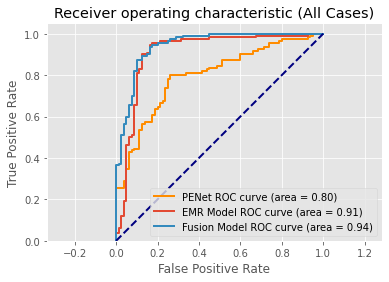

In [22]:
# Performance for all cases
plot_auc(df_test, 'All Cases')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


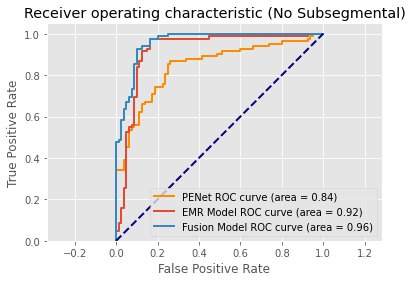

In [23]:
# Performance for non-subsegmental cases
df_test_no_subseg = df_test[
    df_test[PE_TYPE_COL] != 'subsegmental']
plot_auc(df_test_no_subseg, 'No Subsegmental')

<Figure size 432x288 with 0 Axes>

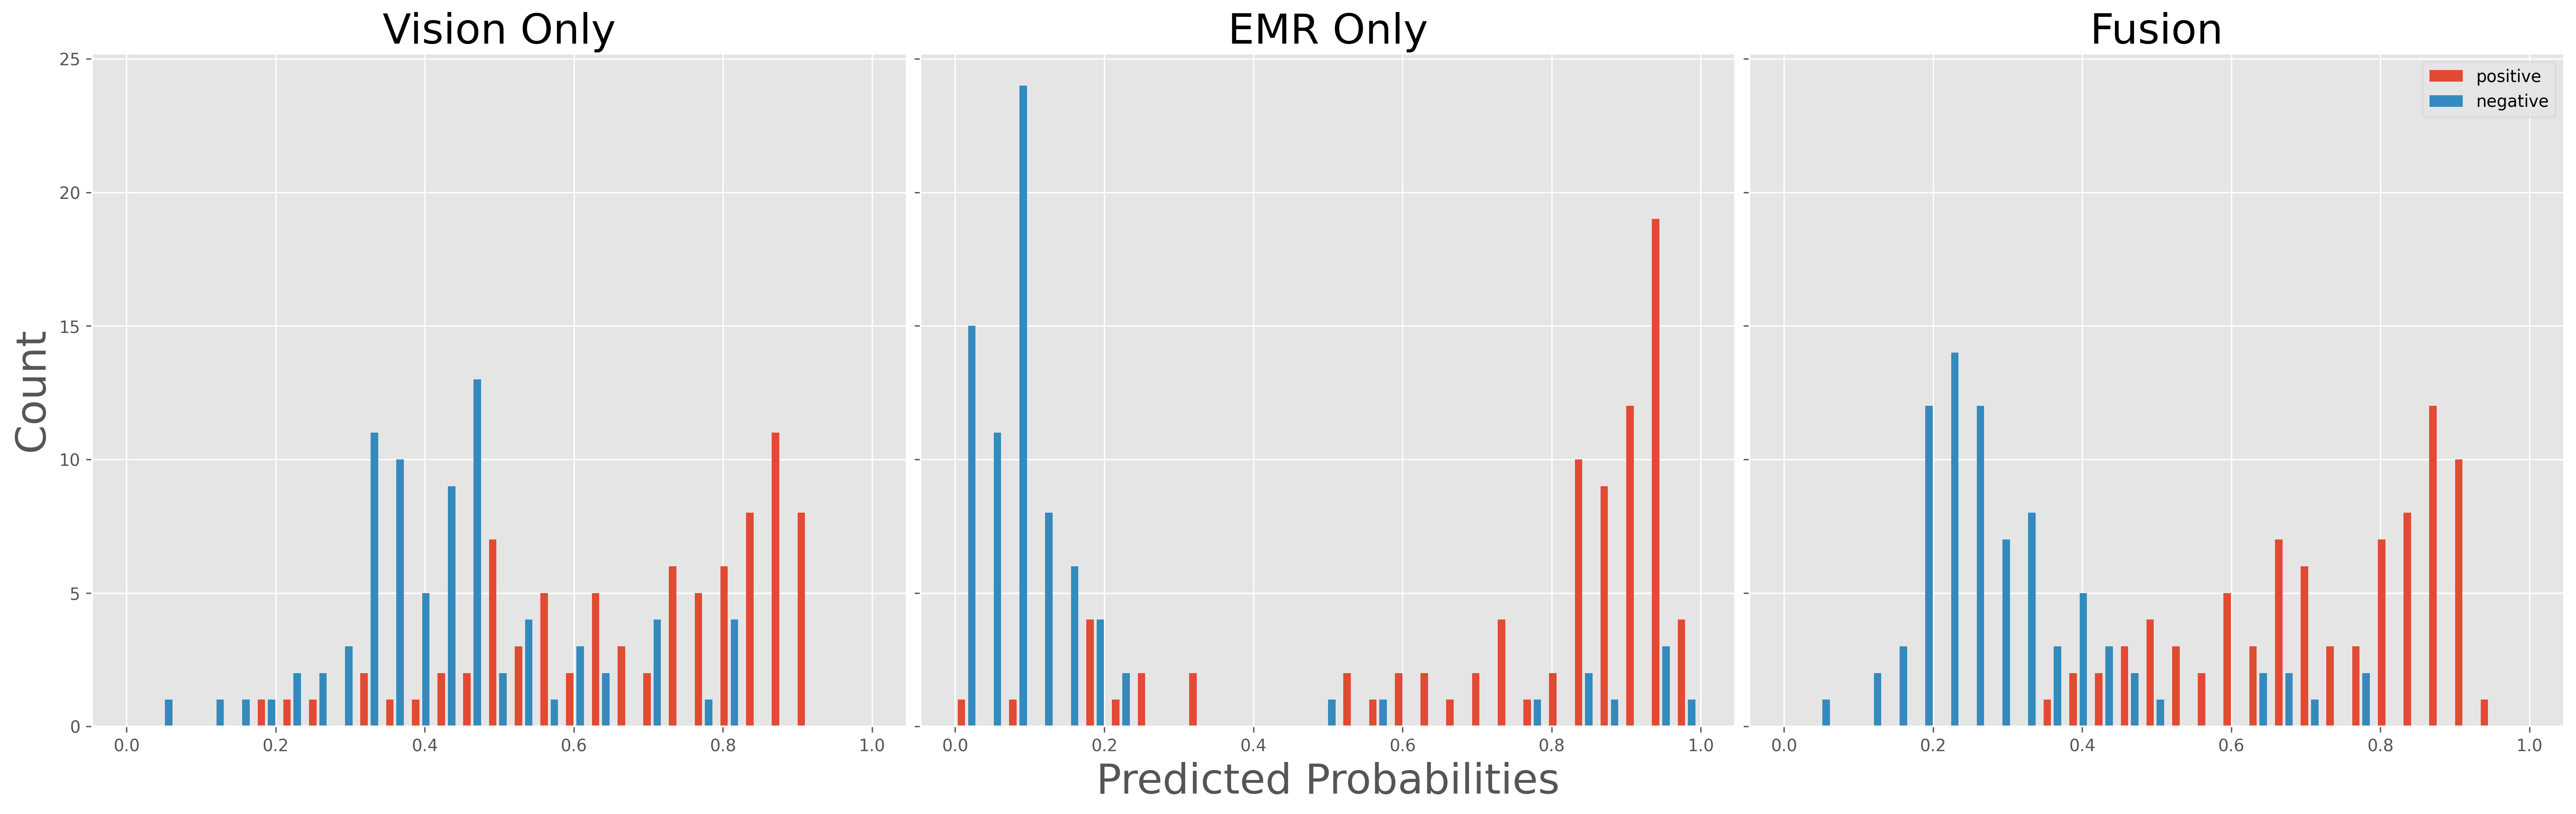

In [25]:
# Visualize histogram of Predicted Probs

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# style
plt.clf()
plt.style.use('ggplot')
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10) 
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(21,6), dpi=300)
bins = np.linspace(0, 1, 30)

# seperate cases into positive and negative
positive_cases = df_test_no_subseg[
    df_test_no_subseg[LABEL_COL] == 1]
negative_cases = df_test_no_subseg[
    df_test_no_subseg[LABEL_COL] == 0]

# PENet
ax1.hist(
    [positive_cases[VISION_PRED_COL], negative_cases[VISION_PRED_COL]], 
    bins, 
    label=['positive','negative'], 
    width=0.01)

# EMR
ax2.hist(
    [positive_cases[EMR_PRED_COL], negative_cases[EMR_PRED_COL]], 
    bins, 
    label=['positive', 'negative'], 
    width=0.01)

# Fusion
ax3.hist(
    [positive_cases[FUSION_PRED_COL], negative_cases[FUSION_PRED_COL]], 
    bins, 
    label=['positive','negative'], 
    width=0.01)

f.tight_layout(pad=0.5)
plt.legend(loc='upper right')
ax2.set_xlabel("Predicted Probabilities", fontsize = 25)
ax1.set_ylabel("Count", fontsize = 25)
ax1.set_title('Vision Only', fontsize = 25)
ax2.set_title('EMR Only', fontsize = 25)
ax3.set_title('Fusion', fontsize = 25)
plt.show()